各阶数下的参数均值：
       single_gate    two_gate   total_gate        depth       latency
order                                                                 
0         0.000000    0.000000     0.000000     0.000000      0.000000
1         0.250000    0.750000     1.000000     1.000000     20.000000
2        25.000000    5.375000    30.375000    16.125000     89.750000
3       168.545455   33.818182   202.363636    78.909091    572.909091
4       796.979167  151.020833   948.000000   387.208333   2809.708333
5      3230.200000  597.800000  3828.000000  1750.500000  12823.700000


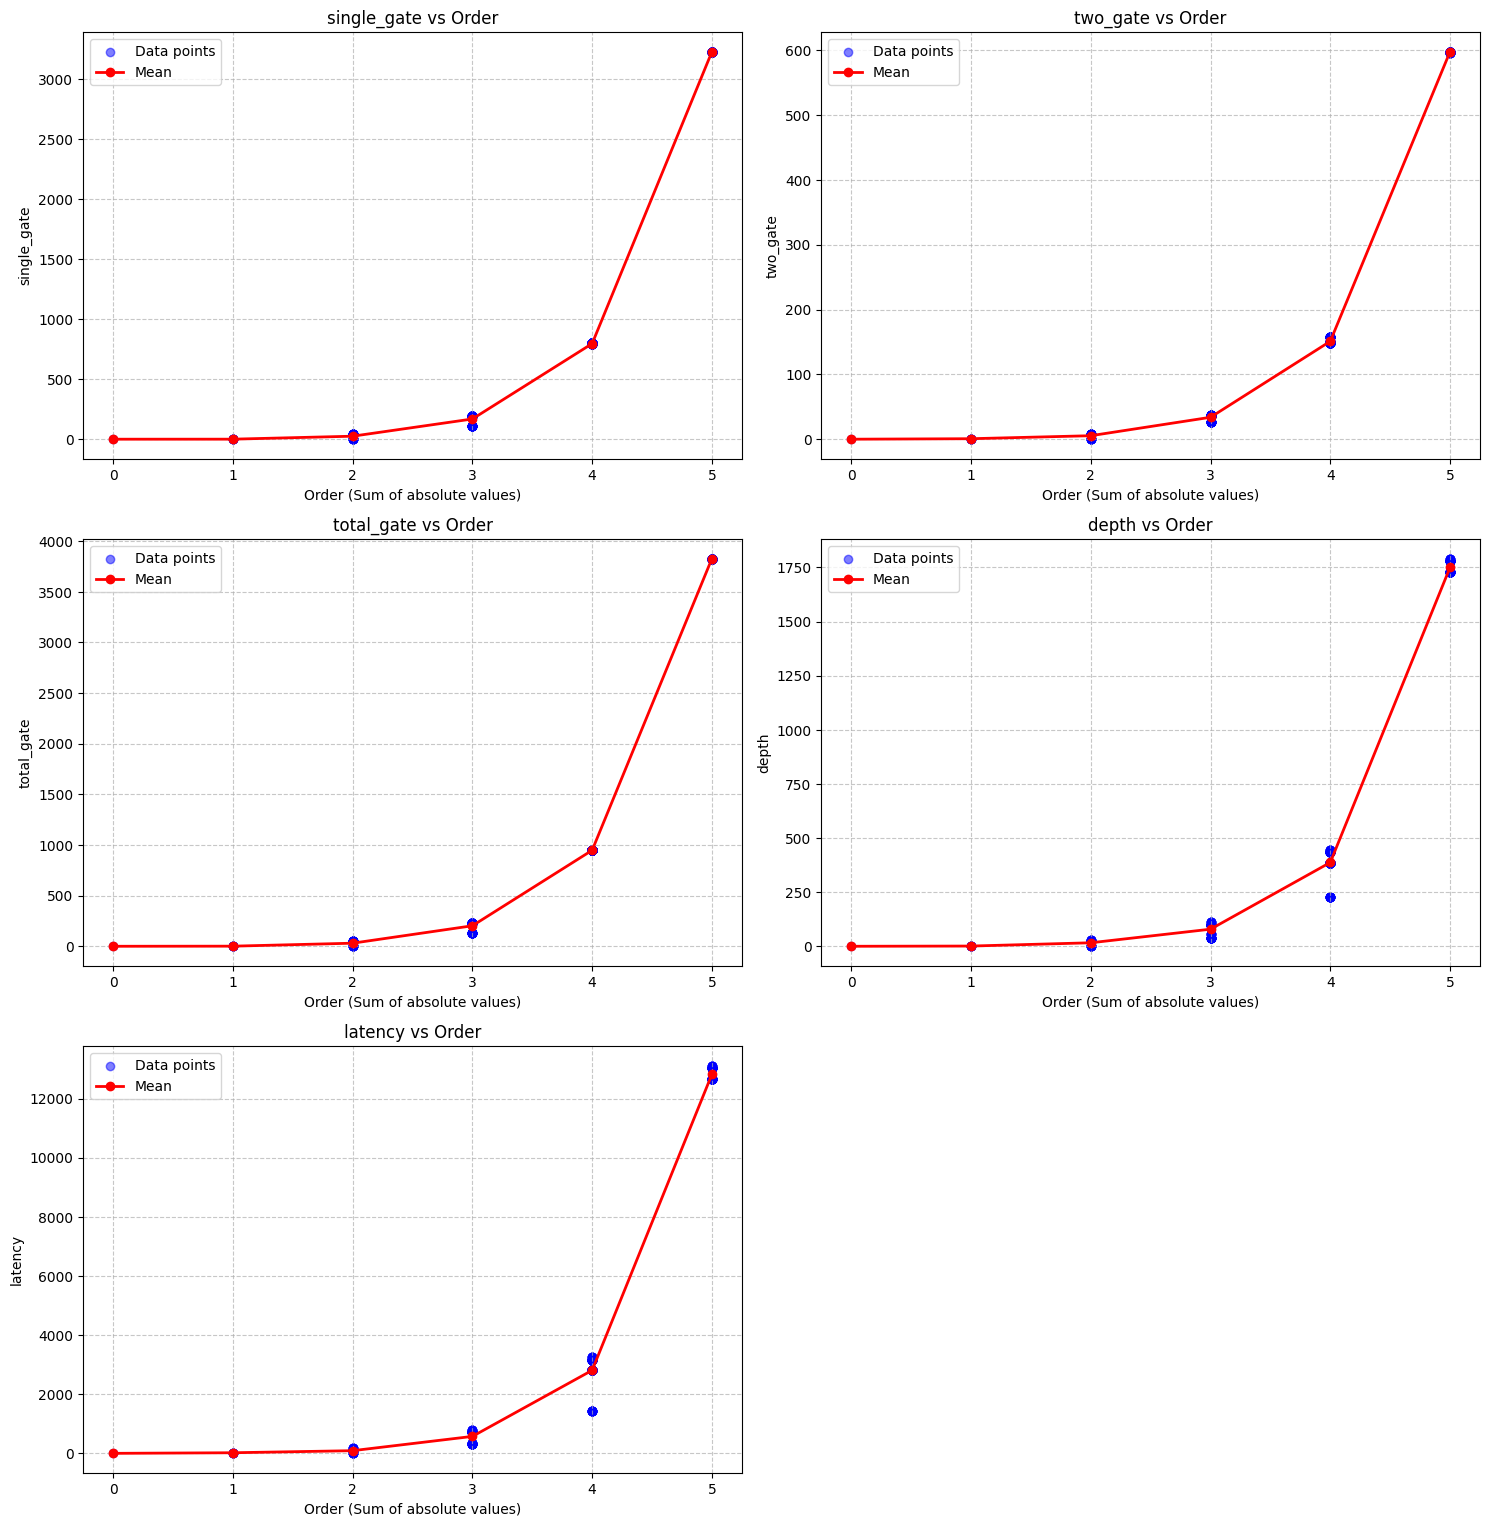

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# 1. 读取数据
# 请确保 CSV 文件在当前目录下，或者修改为正确的文件路径
df = pd.read_csv('result_logic_[abcd].csv')

# 清理列名（去除可能存在的首尾空格）
df.columns = df.columns.str.strip()

# 2. 定义计算阶数的函数
def calculate_order(k_str):
    """
    从字符串 K=[abcd] 中提取数字并计算绝对值之和。
    例如: [-1-0-1-0] -> |(-1)| + |0| + |(-1)| + |0| = 2
    """
    # 使用正则表达式查找所有带符号的整数
    matches = re.findall(r'[+-]\d+', k_str)
    if len(matches) != 4:
        return None
    numbers = [int(m) for m in matches]
    # 阶数 = 绝对值之和
    return sum(abs(n) for n in numbers)

# 3. 应用函数计算每一行的阶数
df['order'] = df['K=[abcd]'].apply(calculate_order)

# 4. 分组统计
# 选择需要分析的数值型列
metrics = ['single_gate', 'two_gate', 'total_gate', 'depth', 'latency']
# 按阶数分组并计算均值
grouped = df.groupby('order')[metrics].mean()

print("各阶数下的参数均值：")
print(grouped)

# (可选) 将统计结果保存为 CSV
grouped.to_csv('grouped_analysis.csv')

# 5. 绘图分析
# 设置画布大小：4行2列
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    # 绘制原始数据散点（蓝色）
    ax.scatter(df['order'], df[metric], alpha=0.5, label='Data points', color='blue')
    
    # 绘制均值曲线（红色）
    ax.plot(grouped.index, grouped[metric], color='red', linewidth=2, label='Mean', marker='o')
    
    # 设置标题和标签
    ax.set_title(f'{metric} vs Order')
    ax.set_xlabel('Order (Sum of absolute values)')
    ax.set_ylabel(metric)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

# 移除多余的空子图（因为只有7个参数，画布有8个位置）
if len(metrics) < len(axes):
    for j in range(len(metrics), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
# 保存图片
plt.savefig('order_analysis.png')
plt.show()

将分析以下手动指定的 (b,c,d) 组合：
   b  c  d
0  0  0  0
1 -1 -1  0
2  0 -1  1


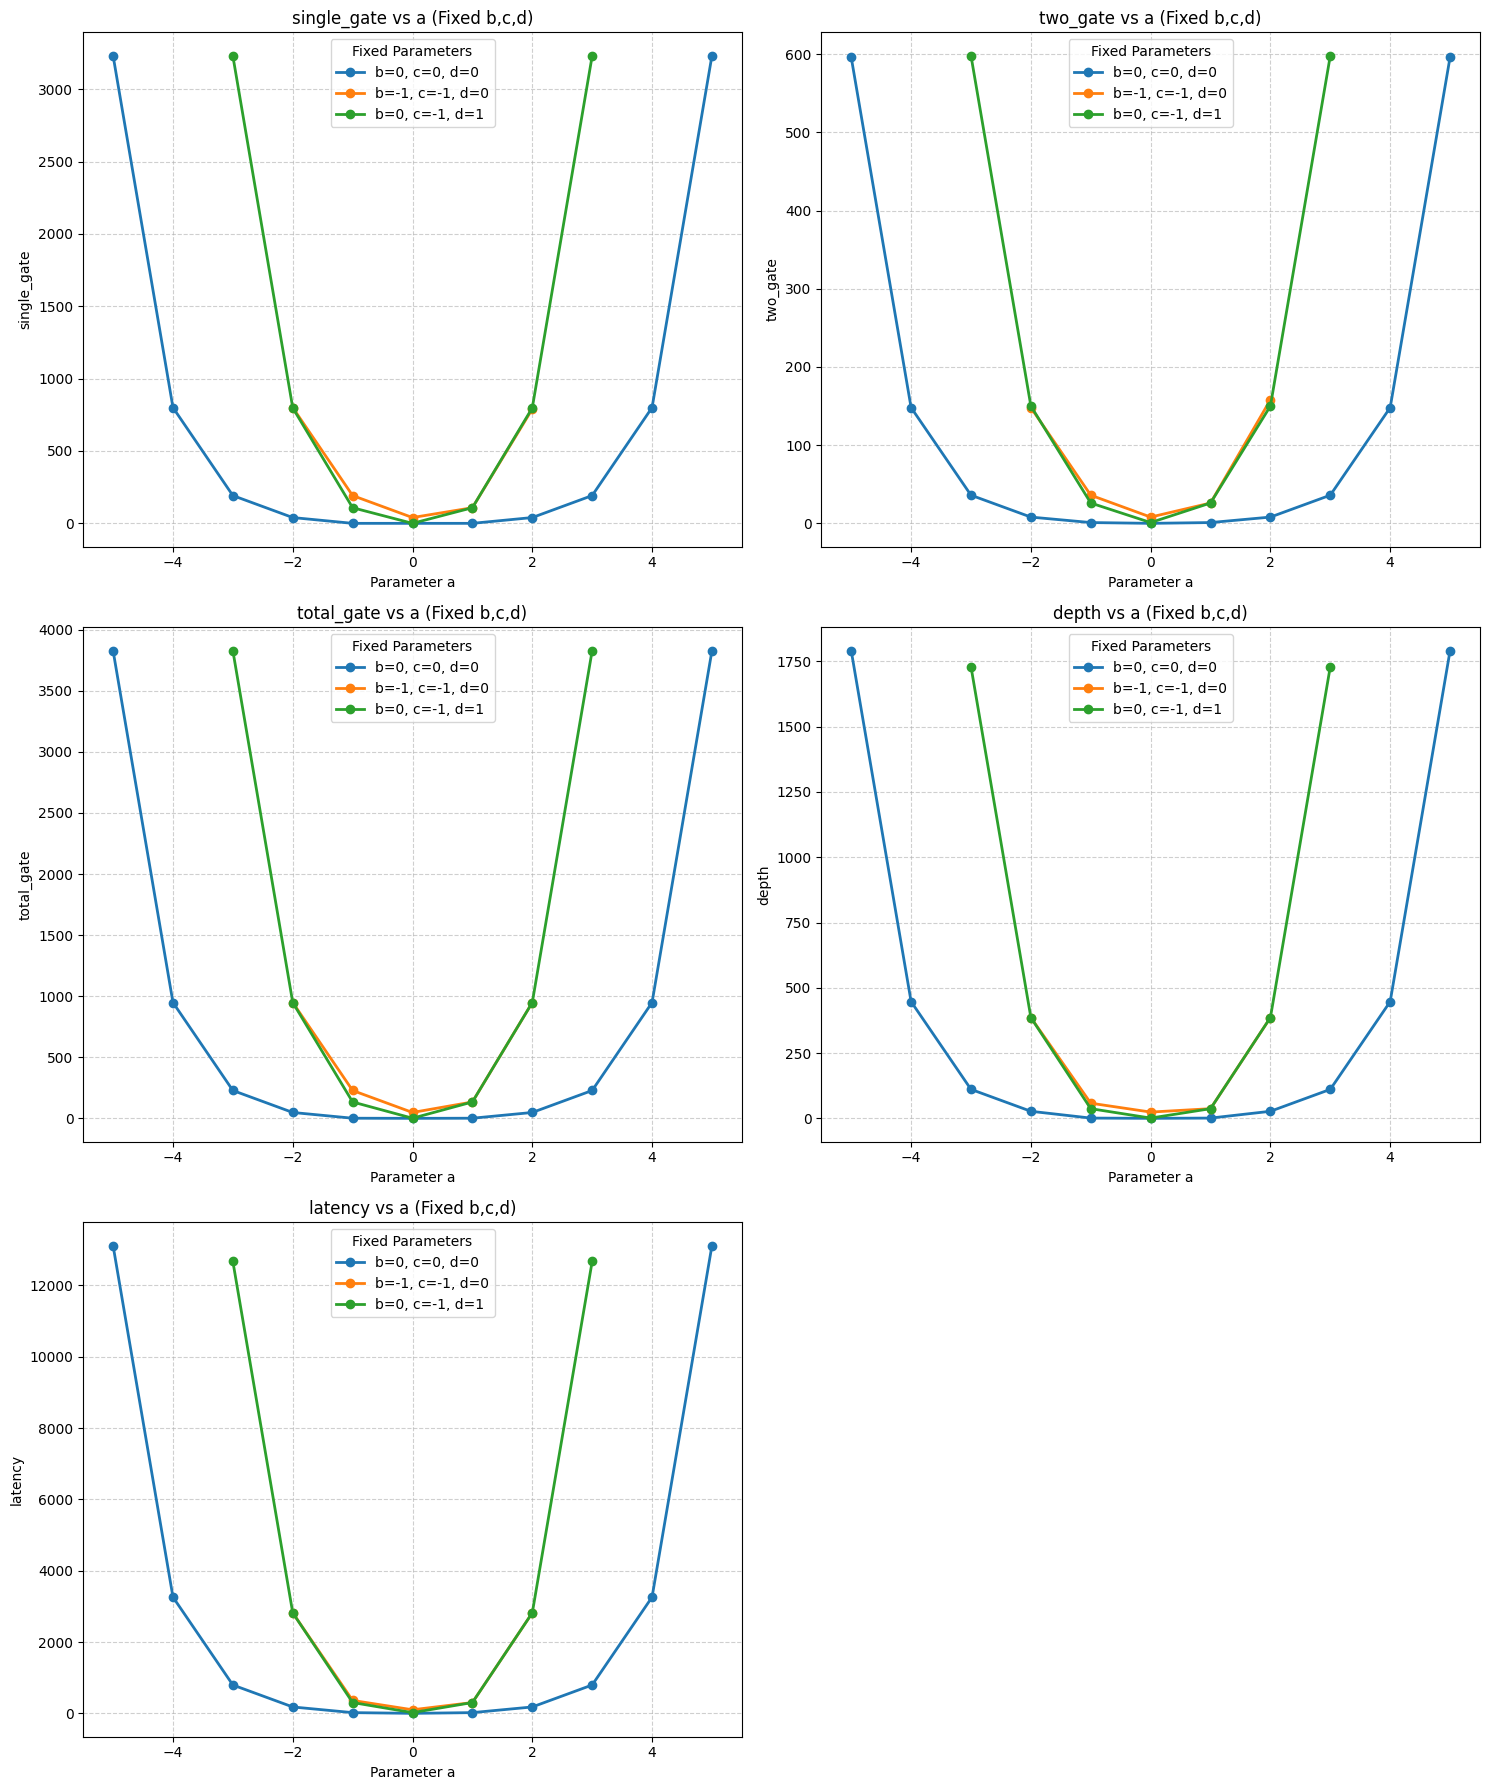

In [8]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# 1. 读取数据
# 请确保 CSV 文件在当前目录下
try:
    df = pd.read_csv('result_logic_[abcd].csv')
except FileNotFoundError:
        
    df = pd.DataFrame()

# 清理列名
df.columns = df.columns.str.strip()

# 2. 核心修改：解析 a, b, c, d
def parse_abcd(k_str):
    """
    解析 K=[a,b,c,d] 字符串，返回 a, b, c, d 四个数值
    """
    # 匹配带符号的整数
    matches = re.findall(r'[+-]?\d+', k_str)
    if len(matches) != 4:
        return None, None, None, None
    return [int(m) for m in matches]

# 将解析结果应用到新的四列
df[['a', 'b', 'c', 'd']] = df['K=[abcd]'].apply(lambda x: pd.Series(parse_abcd(x)))

# 3. 确定分析目标
# 这里定义你想要画出的 b, c, d 组合
# 每一行代表一条你想要在图中看到的线
target_combinations = pd.DataFrame([
    {'b': 0,  'c': 0,  'd': 0},   # 第1组
    {'b': -1, 'c': -1, 'd': 0},   # 第2组
    {'b': 0,  'c': -1, 'd': 1},   # 第3组
    # 你可以在这里继续添加更多组合...
])

print("将分析以下手动指定的 (b,c,d) 组合：")
print(target_combinations)

# 4. 绘图分析
metrics = ['single_gate', 'two_gate', 'total_gate', 'depth', 'latency']

# 设置画布
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    # 注意：这里把原来的 top_bcd_combinations 换成了 target_combinations
    for index, row in target_combinations.iterrows():
        fixed_b, fixed_c, fixed_d = row['b'], row['c'], row['d']
        
        # 筛选数据：b, c, d 符合当前组合
        subset = df[(df['b'] == fixed_b) & 
                    (df['c'] == fixed_c) & 
                    (df['d'] == fixed_d)].copy()
        
        # 如果数据中没有这个组合，跳过不画，避免报错
        if subset.empty:
            print(f"警告: 数据中未找到组合 b={fixed_b}, c={fixed_c}, d={fixed_d}")
            continue

        # 按 a 从小到大排序
        subset = subset.sort_values(by='a')
        
        # 绘制曲线
        label_str = f'b={fixed_b}, c={fixed_c}, d={fixed_d}'
        ax.plot(subset['a'], subset[metric], marker='o', linewidth=2, label=label_str)
    
    # 设置标题和标签
    ax.set_title(f'{metric} vs a (Fixed b,c,d)')
    ax.set_xlabel('Parameter a')
    ax.set_ylabel(metric)
    ax.legend(title='Fixed Parameters')
    ax.grid(True, linestyle='--', alpha=0.6)

# 移除多余子图
if len(metrics) < len(axes):
    for j in range(len(metrics), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('analysis_varying_a.png')
plt.show()

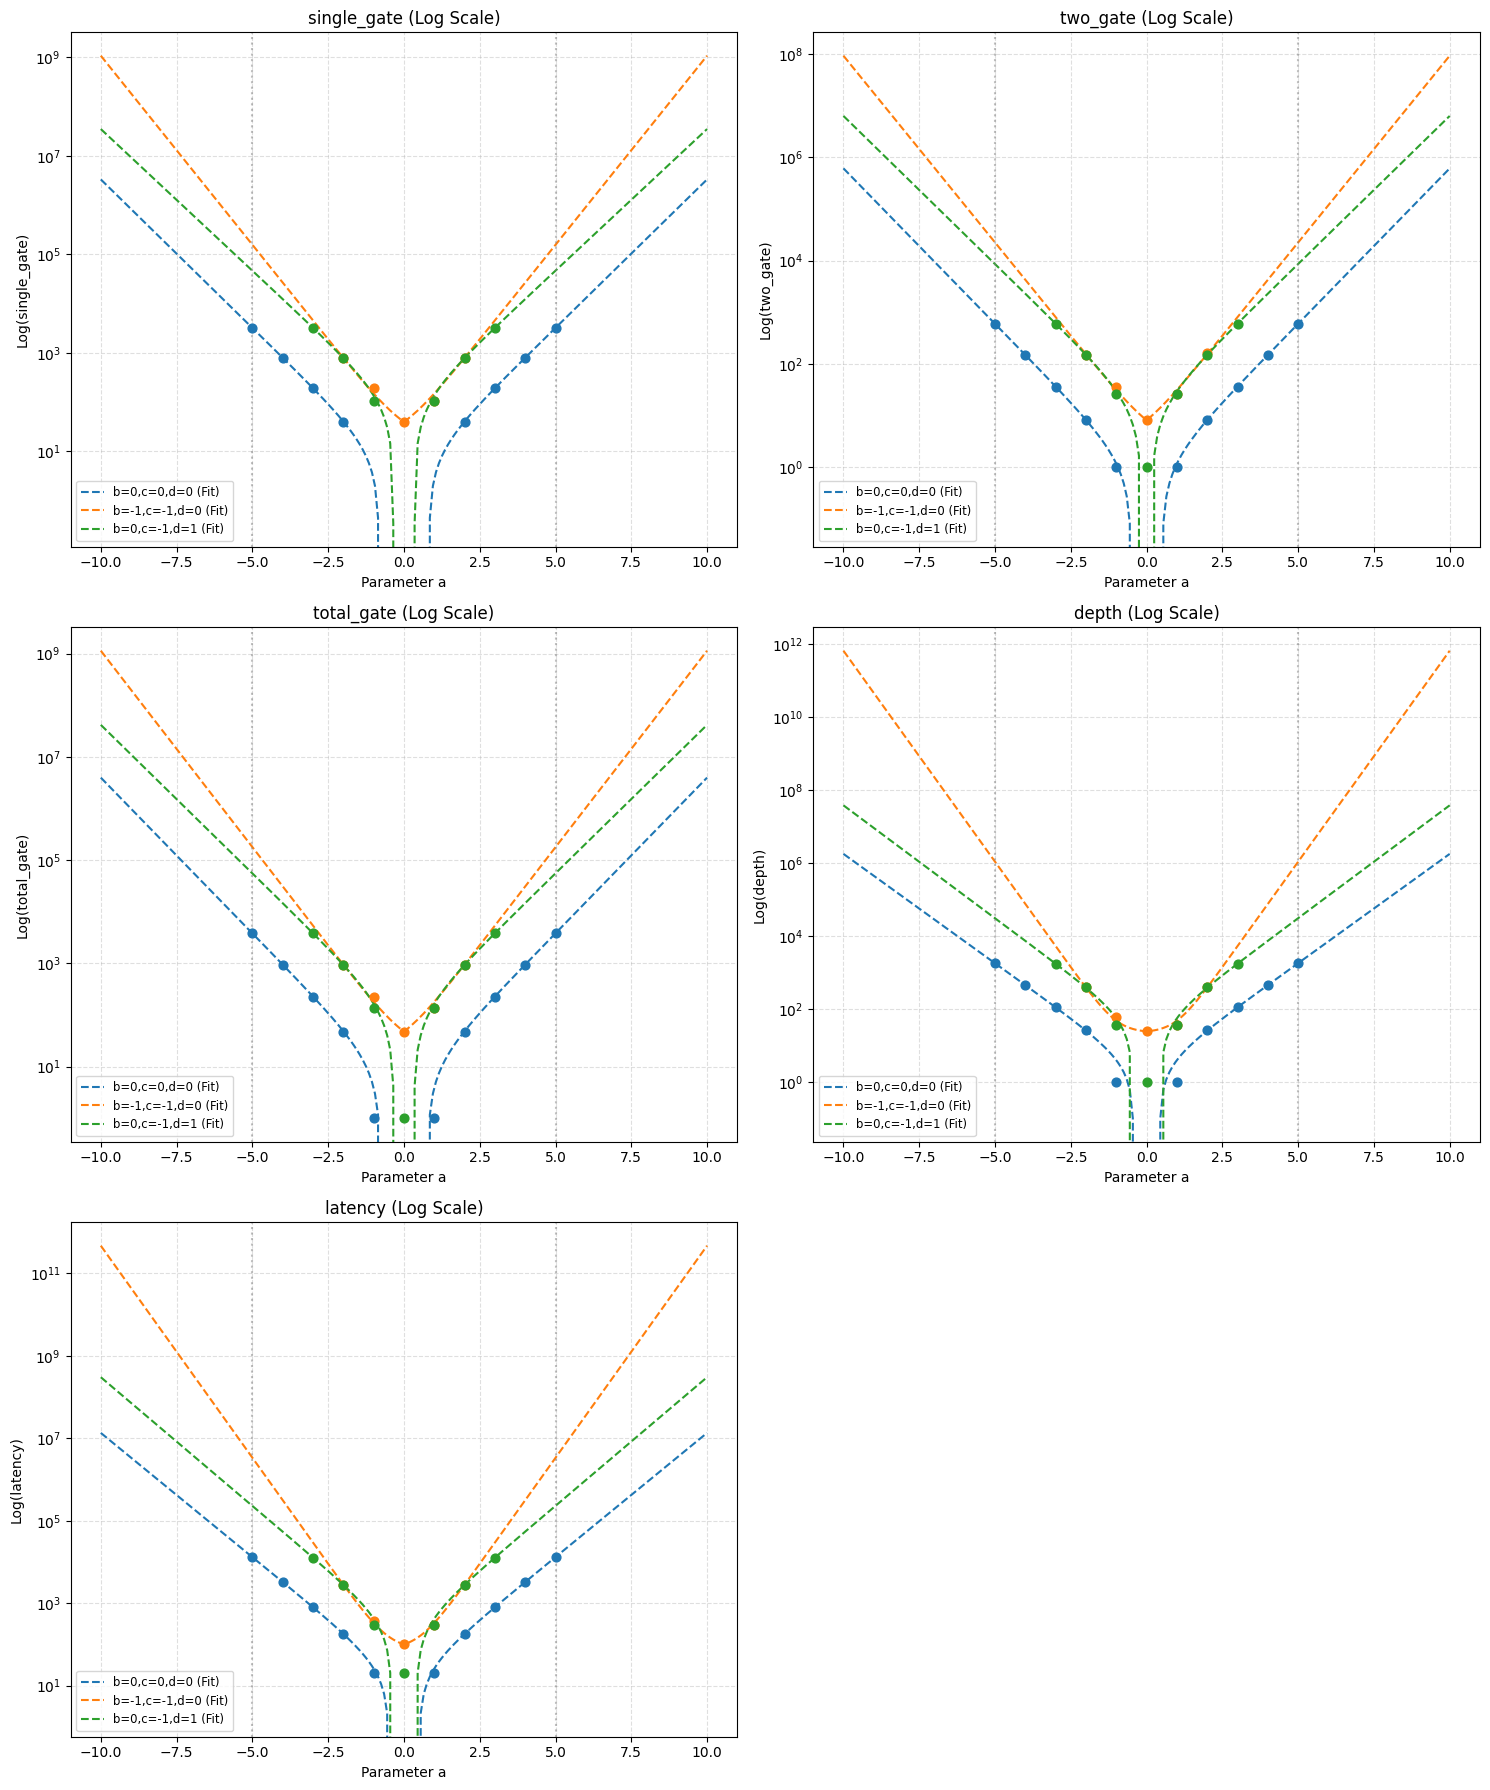

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import re

# 1. 读取数据
try:
    df = pd.read_csv('result_logic_[abcd].csv')
except FileNotFoundError:
    print("错误：未找到 CSV 文件。")
    df = pd.DataFrame()

if not df.empty:
    df.columns = df.columns.str.strip()
    def parse_abcd(k_str):
        matches = re.findall(r'[+-]?\d+', k_str)
        if len(matches) != 4: return None, None, None, None
        return [int(m) for m in matches]
    df[['a', 'b', 'c', 'd']] = df['K=[abcd]'].apply(lambda x: pd.Series(parse_abcd(x)))

# -----------------------------------------------------------
# 2. 定义拟合模型
# -----------------------------------------------------------
def fit_model(x, A, B, C):
    # C 允许数据有一定的基底噪音
    return A * np.exp(B * np.abs(x)) + C

# 3. 指定分析组合
target_combinations = pd.DataFrame([
    {'b': 0,  'c': 0,  'd': 0},
    {'b': -1, 'c': -1, 'd': 0},
    {'b': 0,  'c': -1, 'd': 1},
])

# 4. 绘图
metrics = ['single_gate', 'two_gate', 'total_gate', 'depth', 'latency']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
axes = axes.flatten()

x_pred = np.linspace(-10, 10, 200)

for i, metric in enumerate(metrics):
    ax = axes[i]
    if df.empty: continue

    for index, row in target_combinations.iterrows():
        fixed_b, fixed_c, fixed_d = row['b'], row['c'], row['d']
        
        subset = df[(df['b'] == fixed_b) & 
                    (df['c'] == fixed_c) & 
                    (df['d'] == fixed_d)].copy()
        
        if subset.empty or len(subset) < 3: continue 
        subset = subset.sort_values(by='a')
        label_str = f'b={fixed_b},c={fixed_c},d={fixed_d}'
        
        try:
            # 拟合
            # 注意：对于对数图，初始猜测值很重要，防止 C 拟合为负数导致画图报错
            popt, pcov = curve_fit(fit_model, subset['a'], subset[metric], 
                                   p0=[1, 0.5, 1], bounds=([0, -np.inf, -np.inf], [np.inf, np.inf, np.inf]), maxfev=5000)
            
            y_pred = fit_model(x_pred, *popt)
            
            # 绘图（获取颜色）
            line_plot, = ax.plot(x_pred, y_pred, linestyle='--', 
                                 label=label_str + ' (Fit)', linewidth=1.5)
            line_color = line_plot.get_color()
            
            # 画点
            ax.scatter(subset['a'], subset[metric], color=line_color, s=40, zorder=5)
            
        except Exception as e:
            print(f"拟合失败: {e}")
            line_plot, = ax.plot(subset['a'], subset[metric], marker='o', label=label_str)

    # --- 关键修改：设置纵坐标为对数刻度 ---
    ax.set_yscale('log')
    
    ax.set_title(f'{metric} (Log Scale)')
    ax.set_xlabel('Parameter a')
    ax.set_ylabel(f'Log({metric})')
    
    # 辅助线和图例
    ax.axvline(x=5, color='gray', linestyle=':', alpha=0.5)
    ax.axvline(x=-5, color='gray', linestyle=':', alpha=0.5)
    ax.legend(fontsize='small')
    ax.grid(True, which="both", ls="--", alpha=0.4) # which="both" 显示对数坐标的次级网格

if len(metrics) < len(axes):
    for j in range(len(metrics), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('prediction_log_scale.png')
plt.show()